## Net Return Maximization

<div class="alert alert-block alert-info"> <b>NOTE</b> This tutorial is experiemental. </div>

This section covers budget optimization by maximizing net returns with the insights from a fitted MMM and a user supplied LTV analysis (in channel level).

In net returns maximization, the objective function is define as

\begin{align*}
R & = \sum^K_k (\text{LTV}_k - \text{Cost per Acqusition}_k) \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k - \frac{\text{Spend}_k}{\text{Attribution}_k})  \times \text{Attribution}_k \\
  & = \sum^K_k (\text{LTV}_k \times \text{Attribution}_k  - \text{Spend}_k)
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy

from karpiu.planning.optim import NetProfitMaximizer
from karpiu.planning.common import calculate_marginal_cost, generate_cost_report
from karpiu.explainability import AttributorBeta as Attributor

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [4]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-10")
optim_channels = mmm.get_spend_cols()
optim_channels

['promo', 'radio', 'search', 'social', 'tv']

Given the customers life-time value (LTV), one can run the revenue maximization.

In [5]:
ltv_arr = [48.5, 52.5, 38.6, 35.8, 60.8]

### Optimization with Total Budget Constraints

In [6]:
%%time
maximizer = NetProfitMaximizer(
    ltv_arr=ltv_arr,
    model=mmm,
    optim_channels=optim_channels,
    budget_start=budget_start,
    budget_end=budget_end,
)
optim_spend_df = maximizer.optimize(maxiter=500, eps=1e-3)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 914747.1640537283
            Iterations: 66
            Function evaluations: 396
            Gradient evaluations: 66
CPU times: user 957 ms, sys: 564 ms, total: 1.52 s
Wall time: 760 ms


In [7]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [8]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 102991
Total Budget: 145490


#### Budget Allocation

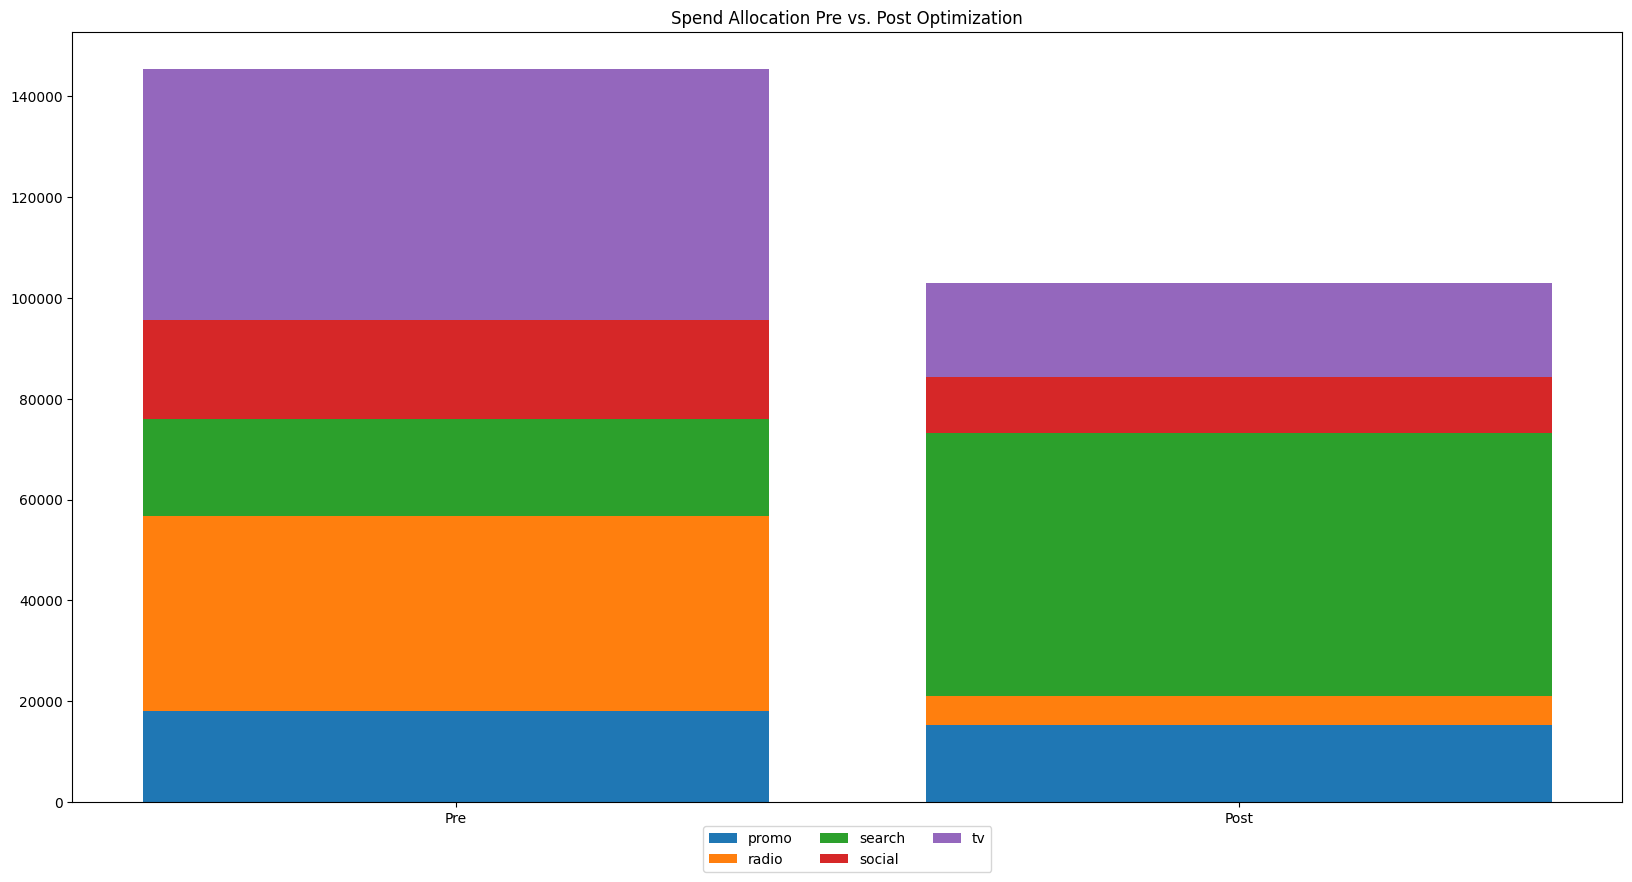

In [9]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label)
    bottom += plot_data[:, idx]
ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Validation

#### Average and Marginal Cost Change

In general, one should expect when LTV is greater than the marginal cost under the pre-optimized spend, there should be an increase of spend in the optimal budget. 

In [10]:
df = mmm.get_raw_df()

In [11]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
)
cost_report["ltv"] = ltv_arr
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,ltv
promo,39.93731,37.26563,43.74898,39.19018,18.04200,15.26901,48.50000
radio,78.09734,48.99480,88.02650,53.77623,38.77000,5.74445,52.50000
search,20.82067,29.94628,22.38461,31.40972,19.07300,52.10211,38.60000
social,40.26705,35.28113,43.40757,37.07927,19.74900,11.10029,35.80000
tv,63.50575,53.46605,70.42736,59.23330,49.85600,18.77513,60.80000


In [12]:
pre_mc = cost_report["pre-opt-marginal-cost"].values
overspend = pre_mc > (cost_report["ltv"].values * 1.1)
underspend = pre_mc < (cost_report["ltv"].values * 0.9)
spend_delta = cost_report["post-opt-spend"].values - cost_report["pre-opt-spend"].values 
assert np.all(spend_delta[overspend] < 0)
assert np.all(spend_delta[underspend] > 0)

After all, a general condition of marginal cost lower than LTV should be met.

In [13]:
post_mc = cost_report["post-opt-marginal-cost"].values

In [14]:
assert np.all(post_mc < cost_report["ltv"].values * 1.1)

#### Marginal Attribution Check 

Because this optimization is dependent on the attribution logic, another validation can be done by deriving a marginal revenue based on attribution. First, compute the baseline revenue in the current spend condition.

In [15]:
attr_obj = Attributor(
    mmm,
    attr_regressors=optim_channels,
    start=budget_start,
    end=budget_end,
    df=optim_spend_df,
)
res = attr_obj.make_attribution()

_, spend_attr_df, spend_df, _ = res
base_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
base_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
base_rev = base_spend_attr_matrix * (ltv_arr)
base_net_arr = base_rev - base_spend_matrix
baseline_net_rev = base_net_arr.sum()

In [16]:
baseline_net_rev

22808.909897395708

`base_net_arr` now holds net returns for each channel. `baseline_net_rev` holds the total baseline net returns.

Now, one can iteratively simulate scenarios for each channel with additional spend and derive the delta of net returns between the scenario and the baseline.

In [17]:
input_mask = (optim_spend_df["date"] >= budget_start) & (
    optim_spend_df["date"] <= budget_end
)

In [18]:
delta = 1e-1

In [19]:
new_net_revs = np.empty(len(optim_channels))
for idx, ch in enumerate(optim_channels):
    new_spend_df = deepcopy(optim_spend_df)
    delta_matrix = np.zeros_like(new_spend_df.loc[input_mask, optim_channels])
    delta_matrix[:, idx] += delta
    new_spend_df.loc[input_mask, optim_channels] += delta_matrix
    attr_obj = Attributor(
        mmm,
        attr_regressors=optim_channels,
        start=budget_start,
        end=budget_end,
        df=new_spend_df,
    )
    res = attr_obj.make_attribution()
    _, spend_attr_df, spend_df, _ = res
    new_spend_attr_matrix = np.sum(spend_attr_df[optim_channels].values, 0)
    new_spend_matrix = np.sum(spend_df[optim_channels].values, 0)
    new_rev = new_spend_attr_matrix * (ltv_arr)
    new_net_arr = new_rev - new_spend_matrix
    new_net_revs[idx] = new_net_arr.sum()

Now, `new_net_revs` net returns of each scenario with small incremental of spend of such channel.

In [20]:
new_net_revs - baseline_net_rev

array([-0.21558345, -0.05941711, -0.243821  , -0.18940368, -0.00666856])

Users should see negative delta for all scenarios.

### Run optimization with an additional constraint

`.generate_individual_channel_constraints()` is designed to help to generate convenient invidiaul budget constraints with respect to the total budget. For example, by specifying `delta=0.2`, one should expect the total resulting spend of the channel will be within $\pm 20 \%$ of the original budget.

In [21]:
# maximizer2 = RevenueMaximizer(
#     ltv_arr=ltv_arr,
#     model=mmm,
#     optim_channel=optim_channels,
#     budget_start=budget_start,
#     budget_end=budget_end,
#     spend_scaler=10.0,
# )

# ind_constraints = maximizer2.generate_individual_channel_constraints(delta=0.2)
# maximizer2.add_constraints(ind_constraints)
# optim_spend_df2 = maximizer2.optimize(maxiter=1000, eps=1e-3)

# new_cost_report = generate_cost_report(
#     model=mmm,
#     channels=optim_channels,
#     start=budget_start,
#     end=budget_end,
#     pre_spend_df=df,
#     post_spend_df=optim_spend_df2,
# )
# new_cost_report["ltv"] = ltv_arr
# new_cost_report